Missing values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

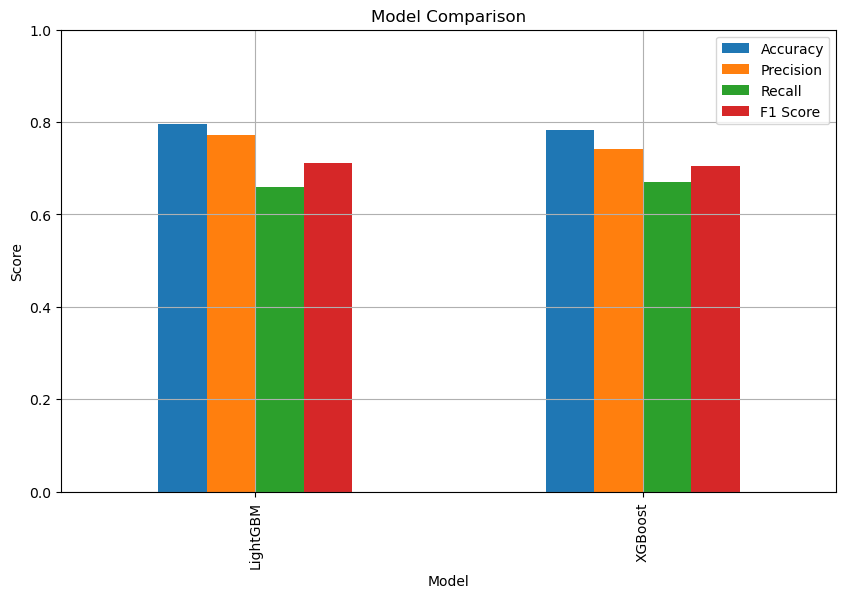

In [6]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Load data
train_df = pd.read_csv("Titanic_train.csv")
test_df = pd.read_csv("Titanic_test.csv")

# EDA 
print("Missing values:\n", train_df.isnull().sum())

# Fill missing values
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

# Drop 'Cabin' due to excessive missing data
train_df.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'], inplace=True)

# Encode categorical variables
le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
train_df['Embarked'] = le.fit_transform(train_df['Embarked'])

# Features & Target 
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# LightGBM 
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

# XGBoost 
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluation 
def print_metrics(y_true, y_pred, model_name):
    print(f"\n--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

print_metrics(y_test, y_pred_lgbm, "LightGBM")
print_metrics(y_test, y_pred_xgb, "XGBoost")

# Visualization
scores = {
    "Model": ["LightGBM", "XGBoost"],
    "Accuracy": [accuracy_score(y_test, y_pred_lgbm), accuracy_score(y_test, y_pred_xgb)],
    "Precision": [precision_score(y_test, y_pred_lgbm), precision_score(y_test, y_pred_xgb)],
    "Recall": [recall_score(y_test, y_pred_lgbm), recall_score(y_test, y_pred_xgb)],
    "F1 Score": [f1_score(y_test, y_pred_lgbm), f1_score(y_test, y_pred_xgb)]
}

scores_df = pd.DataFrame(scores)
scores_df.set_index("Model").plot(kind="bar", figsize=(10, 6), ylim=(0, 1), title="Model Comparison")
plt.ylabel("Score")
plt.grid(True)
plt.show()
